## Import

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import CountVectorizer

In [38]:
# matplotlib 한글 패치
from matplotlib import font_manager, rc
import platform

if platform.system() == 'Windows':
    rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin': # Mac
    rc('font', family='AppleGothic')
else: #linux
    rc('font', family='NanumGothic')

## 파일 불러오기

In [39]:
# .. 상위 폴더
train_pd = pd.read_csv('../../../../data/train.csv')
train_pd

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0
...,...,...,...,...,...,...
9319,boostcamp-sts-v1-train-9319,petition-sampled,교원능력개발평가에서 교원이 보호받을 수 있는 장치를 마련해야합니다,본인이 납부한 국민연금 금액을 기준으로 대출을 받을 수 있는 제도를 마련해 주세요,0.2,0.0
9320,boostcamp-sts-v1-train-9320,petition-sampled,여성가족부의 폐지를 원합니드,여성가족부 폐지를 청원 합니다.,4.2,1.0
9321,boostcamp-sts-v1-train-9321,petition-sampled,국회의원들 월급좀 줄여주세요,공무원 봉급좀 줄이지좀 마세요,0.6,0.0
9322,boostcamp-sts-v1-train-9322,slack-sampled,오늘 못한 점심은 다음에 다시 츄라이 하기로 해요!!,오늘 못먹은 밥은 꼭 담에 먹기로 하고요!!,3.2,1.0


In [40]:
train_pd.describe()

,label,binary-label
count,9324.000000,9324.000000
mean,1.849968,0.389532
std,1.602212,0.487670
min,0.000000,0.000000
25%,0.200000,0.000000
50%,1.600000,0.000000
75%,3.400000,1.000000
max,5.000000,1.000000


## NA check

In [41]:
# 전체 데이터프레임

train_pd.isnull().values.any()

False

In [42]:
# 각 칼럼 별 NaN check

print(train_pd['sentence_1'].isnull().values.any())
print(train_pd['sentence_2'].isnull().values.any())
print(train_pd['label'].isnull().values.any())
print(train_pd['binary-label'].isnull().values.any())

False
False
False
False


## Column engineering

In [43]:
# apply 함수로 일괄 적용

# sentence 합치기
train_pd['sentence_a'] = train_pd['sentence_1'] + ' ' + train_pd['sentence_2']

# 공백 기준으로 토큰 나누기
train_pd['tokens_a']=train_pd['sentence_a'].apply(lambda x: x.split())
train_pd['tokens_1']=train_pd['sentence_1'].apply(lambda x: x.split())
train_pd['tokens_2']=train_pd['sentence_2'].apply(lambda x: x.split())

# 문장 길이, 토큰 개수 칼럼 만들기
train_pd['sen_len_a']=train_pd['sentence_a'].apply(lambda x: len(x))
train_pd['sen_len_1']=train_pd['sentence_1'].apply(lambda x: len(x))
train_pd['sen_len_2']=train_pd['sentence_2'].apply(lambda x: len(x))

train_pd['tok_count_a']=train_pd['tokens_a'].apply(lambda x: len(x))
train_pd['tok_count_1']=train_pd['tokens_1'].apply(lambda x: len(x))
train_pd['tok_count_2']=train_pd['tokens_2'].apply(lambda x: len(x))

# label 단순화, 소숫점 버림
train_pd['simple_label'] = train_pd['label'].apply(lambda x: int(x))

train_pd.head()

,id,source,sentence_1,sentence_2,label,binary-label,sentence_a,tokens_a,tokens_1,tokens_2,sen_len_a,sen_len_1,sen_len_2,tok_count_a,tok_count_1,tok_count_2,simple_label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0,"스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~ 반전도 있고,...","[스릴도있고, 반전도, 있고, 여느, 한국영화, 쓰레기들하고는, 차원이, 다르네요~...","[스릴도있고, 반전도, 있고, 여느, 한국영화, 쓰레기들하고는, 차원이, 다르네요~]","[반전도, 있고,사랑도, 있고재미도있네요.]",59,38,20,11,8,3,2
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0,"앗 제가 접근권한이 없다고 뜹니다;; 오, 액세스 권한이 없다고 합니다.","[앗, 제가, 접근권한이, 없다고, 뜹니다;;, 오,, 액세스, 권한이, 없다고, ...","[앗, 제가, 접근권한이, 없다고, 뜹니다;;]","[오,, 액세스, 권한이, 없다고, 합니다.]",40,20,19,10,5,5,4
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0,주택청약조건 변경해주세요. 주택청약 무주택기준 변경해주세요.,"[주택청약조건, 변경해주세요., 주택청약, 무주택기준, 변경해주세요.]","[주택청약조건, 변경해주세요.]","[주택청약, 무주택기준, 변경해주세요.]",33,14,18,5,2,3,2
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0,입사후 처음 대면으로 만나 반가웠습니다. 화상으로만 보다가 리얼로 만나니 정말 반가...,"[입사후, 처음, 대면으로, 만나, 반가웠습니다., 화상으로만, 보다가, 리얼로, ...","[입사후, 처음, 대면으로, 만나, 반가웠습니다.]","[화상으로만, 보다가, 리얼로, 만나니, 정말, 반가웠습니다.]",51,22,28,11,5,6,3
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0,뿌듯뿌듯 하네요!! 꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,"[뿌듯뿌듯, 하네요!!, 꼬옥, 실제로, 한번, 뵈어요, 뿌뿌뿌~!~!]","[뿌듯뿌듯, 하네요!!]","[꼬옥, 실제로, 한번, 뵈어요, 뿌뿌뿌~!~!]",32,10,21,7,2,5,0


# EDA by label

### value counts

In [44]:
train_pd['simple_label'].value_counts().sort_index()

0    3711
1    1368
2    1137
3    1715
4    1302
5      91
Name: simple_label, dtype: int64

### label 별 데이터 수 및 비율 시각화

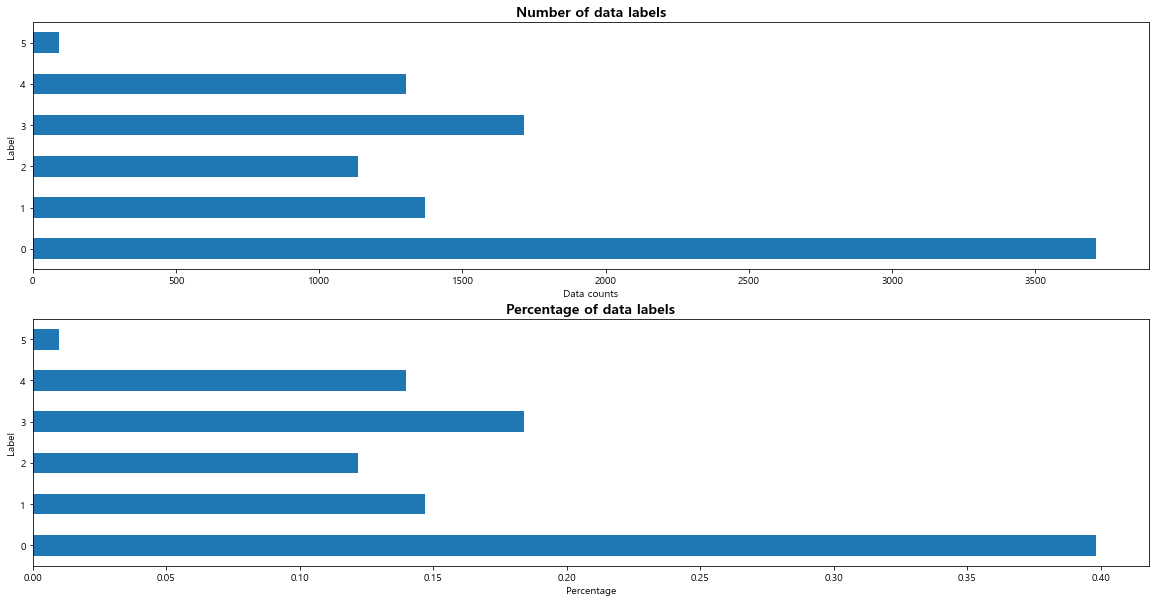

In [45]:
fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(211)
ax1 = train_pd['simple_label'].value_counts().sort_index().plot(kind='barh')
ax1.set_title("Number of data labels", fontsize=14, fontweight='bold')
ax1.set_xlabel("Data counts", fontsize = 10)
ax1.set_ylabel("Label")


ax2 = fig.add_subplot(212)
ax2 = train_pd['simple_label'].value_counts(normalize=True).sort_index().plot(kind='barh')
ax2.set_title("Percentage of data labels", fontsize=14, fontweight='bold')
ax2.set_xlabel("Percentage", fontsize = 10)
ax2.set_ylabel("Label")

plt.show()

0 라벨 데이터의 숫자가 많고 그 비율 또한 상당히 높다. 5 라벨 데이터의 숫자와 비율은 반면에 매우 적고 매우 낮다.   
0 라벨 데이터에 대해선 예측을 잘하거나 또는 0 라벨로 과하게 치우칠 수도 있을 것 같다.   
5 라벨 데이터의 수가 적어서 5라벨을 제대로 예측할 수 있을까 걱정이 된다.   

### label 별 문장 길이 min, mean, max

In [71]:
train_pd.groupby('simple_label')['sen_len_a'].agg(['max','mean','min'])

,max,mean,min
simple_label,,,
0,165,45.836702,18
1,157,43.964181,16
2,165,45.802111,18
3,195,54.064140,16
4,209,53.089094,16
5,197,35.670330,20


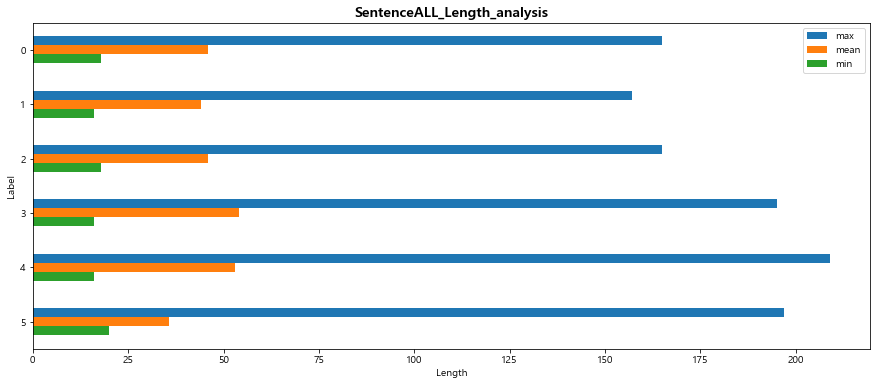

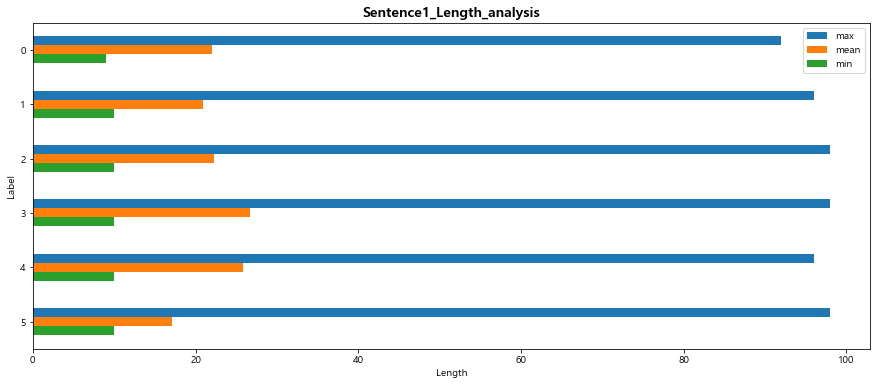

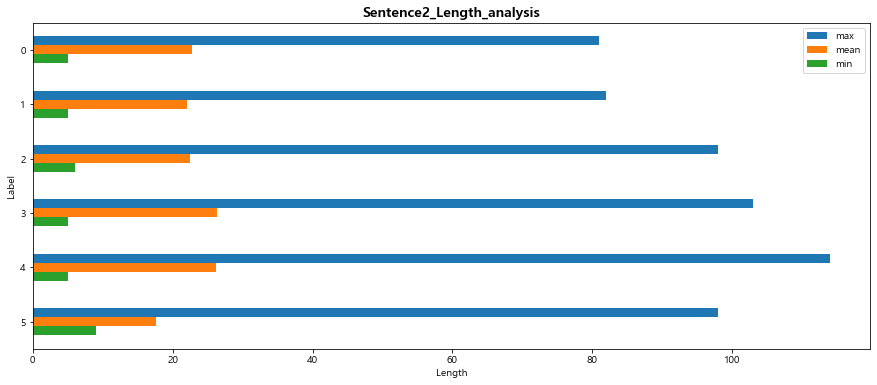

In [46]:
ax1 = fig.add_subplot(311)
ax1 = train_pd.groupby('simple_label')['sen_len_a'].agg(['max','mean','min']).sort_index().plot(kind='barh',figsize=(15,6))
ax1.set_title("SentenceALL_Length_analysis", fontsize=14, fontweight='bold')
ax1.set_xlabel("Length", fontsize = 10)
ax1.set_ylabel("Label")
ax1.invert_yaxis()

ax2 = fig.add_subplot(312)
ax2 = train_pd.groupby('simple_label')['sen_len_1'].agg(['max','mean','min']).sort_index().plot(kind='barh',figsize=(15,6))
ax2.set_title("Sentence1_Length_analysis", fontsize=14, fontweight='bold')
ax2.set_xlabel("Length", fontsize = 10)
ax2.set_ylabel("Label")
ax2.invert_yaxis()


ax3 = fig.add_subplot(313)
ax3 = train_pd.groupby('simple_label')['sen_len_2'].agg(['max','mean','min']).sort_index().plot(kind='barh',figsize=(15,6))
ax3.set_title("Sentence2_Length_analysis", fontsize=14, fontweight='bold')
ax3.set_xlabel("Length", fontsize = 10)
ax3.set_ylabel("Label")
ax3.invert_yaxis()


plt.show()

문장 1의 최대, 최수 길이는 큰 차이가 없어보인다. 평균은 조금씩 달랐다.   
문장 2의 최대, 최수 길이는 문장 1의 경향성과 조금 달랐다.   
문장 2에서는 문장 1의 최소 길이보다 더 짧은 문장이 등장하였으며   
문장 1의 최대 길이보다 문장 최대 길이가 짧게 나타났다.

### label 별 토큰 개수 min, mean, max

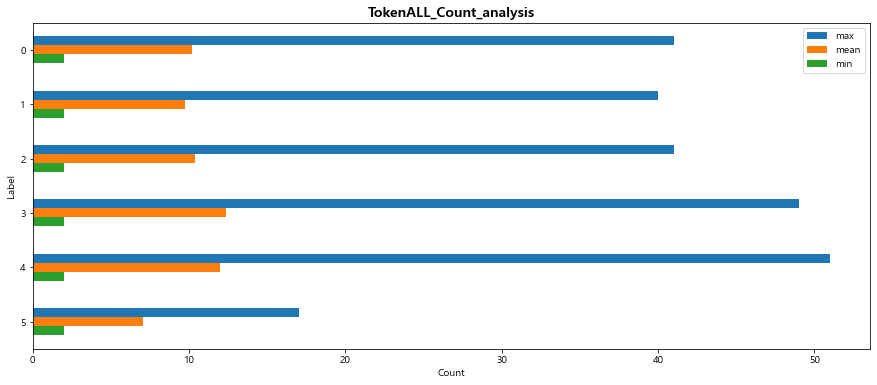

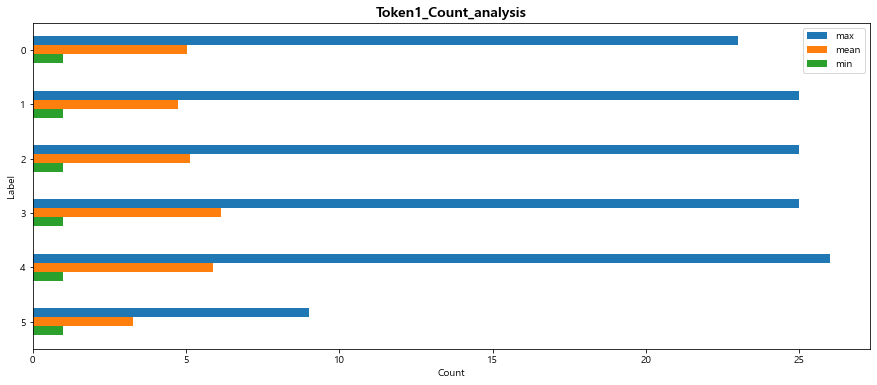

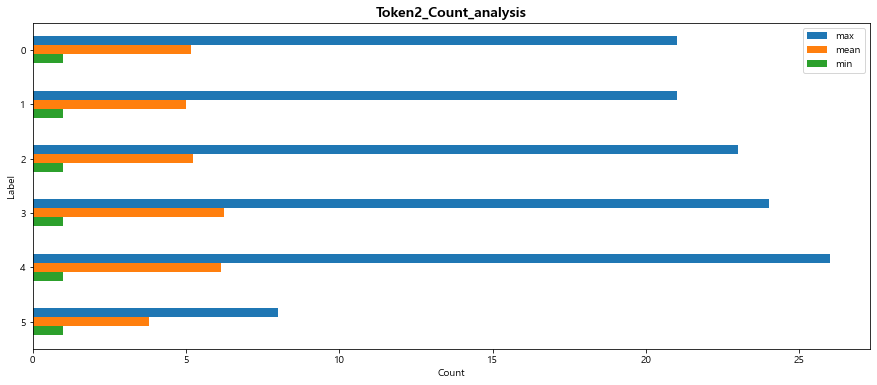

In [47]:
ax1 = fig.add_subplot(311)
ax1 = train_pd.groupby('simple_label')['tok_count_a'].agg(['max','mean','min']).sort_index().plot(kind='barh',figsize=(15,6))
ax1.set_title("TokenALL_Count_analysis", fontsize=14, fontweight='bold')
ax1.set_xlabel("Count", fontsize = 10)
ax1.set_ylabel("Label")
ax1.invert_yaxis()

ax2 = fig.add_subplot(312)
ax2 = train_pd.groupby('simple_label')['tok_count_1'].agg(['max','mean','min']).sort_index().plot(kind='barh',figsize=(15,6))
ax2.set_title("Token1_Count_analysis", fontsize=14, fontweight='bold')
ax2.set_xlabel("Count", fontsize = 10)
ax2.set_ylabel("Label")
ax2.invert_yaxis()

ax3 = fig.add_subplot(313)
ax3 = train_pd.groupby('simple_label')['tok_count_2'].agg(['max','mean','min']).sort_index().plot(kind='barh',figsize=(15,6))
ax3.set_title("Token2_Count_analysis", fontsize=14, fontweight='bold')
ax3.set_xlabel("Count", fontsize = 10)
ax3.set_ylabel("Label")
ax3.invert_yaxis()

plt.show()

라벨 5의 최대 토큰 개수가 매우 작게 나온 것이 눈에 띄인다.   
라벨 5 데이터의 문장이 다른 라벨 데이터의 문장과 마찬가지로 길었음에도   
최대 토큰 개수가 상대적으로 적게 나왔다는 것은   
단어가 잘 나뉘어지지 않았다거나 비문법적인 표현이 많이 사용되었을 가능성이 있다는 것을 의미하지 않을까 싶다.

### 상관 계수

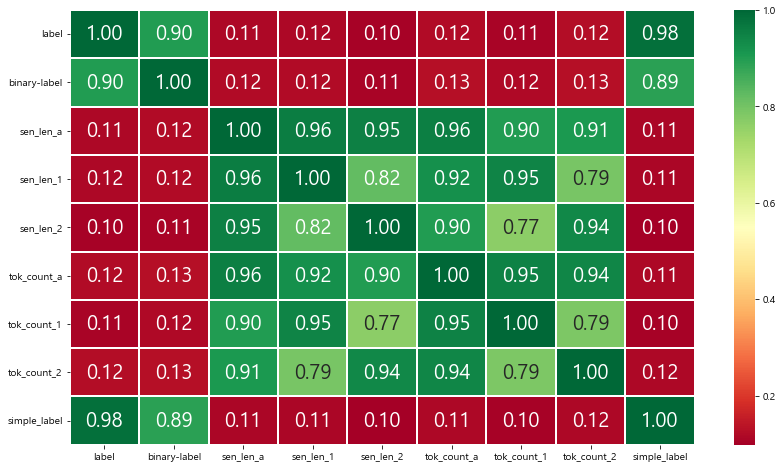

In [48]:
plt.figure(figsize=(14,8))
g=sns.heatmap(train_pd.corr(), cmap='RdYlGn',linewidths=0.2,annot_kws={'size':20},annot=True,fmt='.2f')

라벨과 문장 길이, 토큰 숫자 사이에는 별 다른 상관 관계가 보이지 않았다.    
문장 1과 문장 2의 상관 계수는 0.82의 수준이었다.     
토큰 1과 토큰 2의 상관 계수는 0.79의 수준으로 문장에 비해선 낮은 수준이었다.    
약 0.8의 문장 길이 및 토큰 숫자 상관 계수를 가지는 것인데 두 문장 사이의 관계에서 유의미한가는 더 따져봐야 할듯 하다.    

## 문장 길이, 토큰 개수 histogram

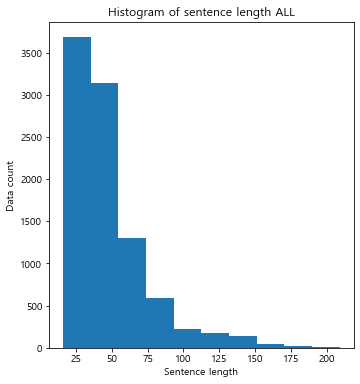

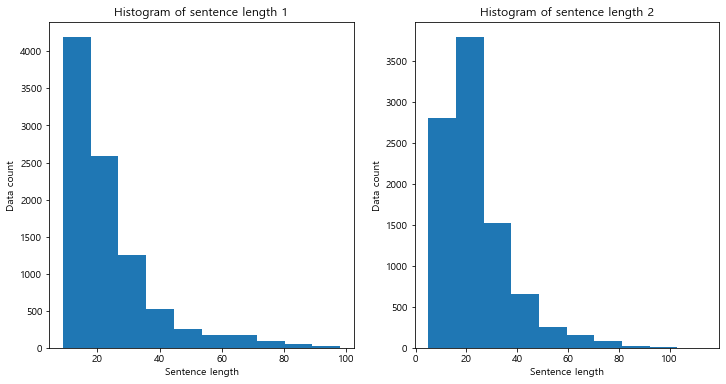

In [49]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax1 = train_pd['sen_len_a'].plot.hist()
ax1.set_title("Histogram of sentence length ALL")
ax1.set_ylabel("Data count")
ax1.set_xlabel("Sentence length")

fig = plt.figure(figsize=(12,6))
ax2 = fig.add_subplot(121)
ax2 = train_pd['sen_len_1'].plot.hist()
ax2.set_title("Histogram of sentence length 1")
ax2.set_ylabel("Data count")
ax2.set_xlabel("Sentence length")

ax3 = fig.add_subplot(122)
ax3 = train_pd['sen_len_2'].plot.hist()
ax3.set_title("Histogram of sentence length 2")
ax3.set_ylabel("Data count")
ax3.set_xlabel("Sentence length")

plt.show()

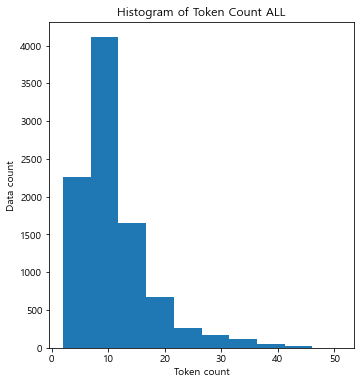

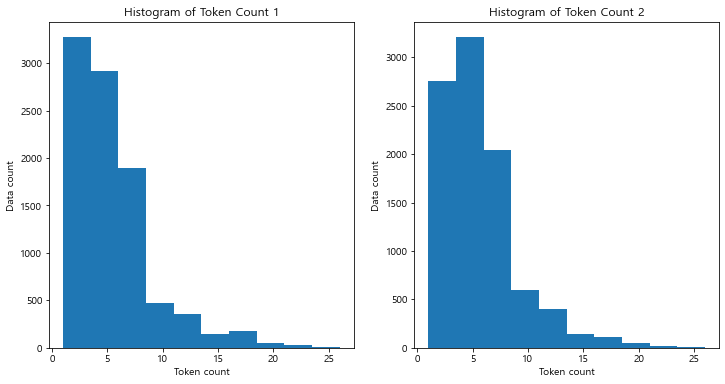

In [50]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax1 = train_pd['tok_count_a'].plot.hist()
ax1.set_title("Histogram of Token Count ALL")
ax1.set_ylabel("Data count")
ax1.set_xlabel("Token count")

fig = plt.figure(figsize=(12,6))
ax2 = fig.add_subplot(121)
ax2 = train_pd['tok_count_1'].plot.hist()
ax2.set_title("Histogram of Token Count 1")
ax2.set_ylabel("Data count")
ax2.set_xlabel("Token count")

ax3 = fig.add_subplot(122)
ax3 = train_pd['tok_count_2'].plot.hist()
ax3.set_title("Histogram of Token Count 2")
ax3.set_ylabel("Data count")
ax3.set_xlabel("Token count")

plt.show()

### 라벨 별 빈출 단어 뽑아보기

#### Label 1

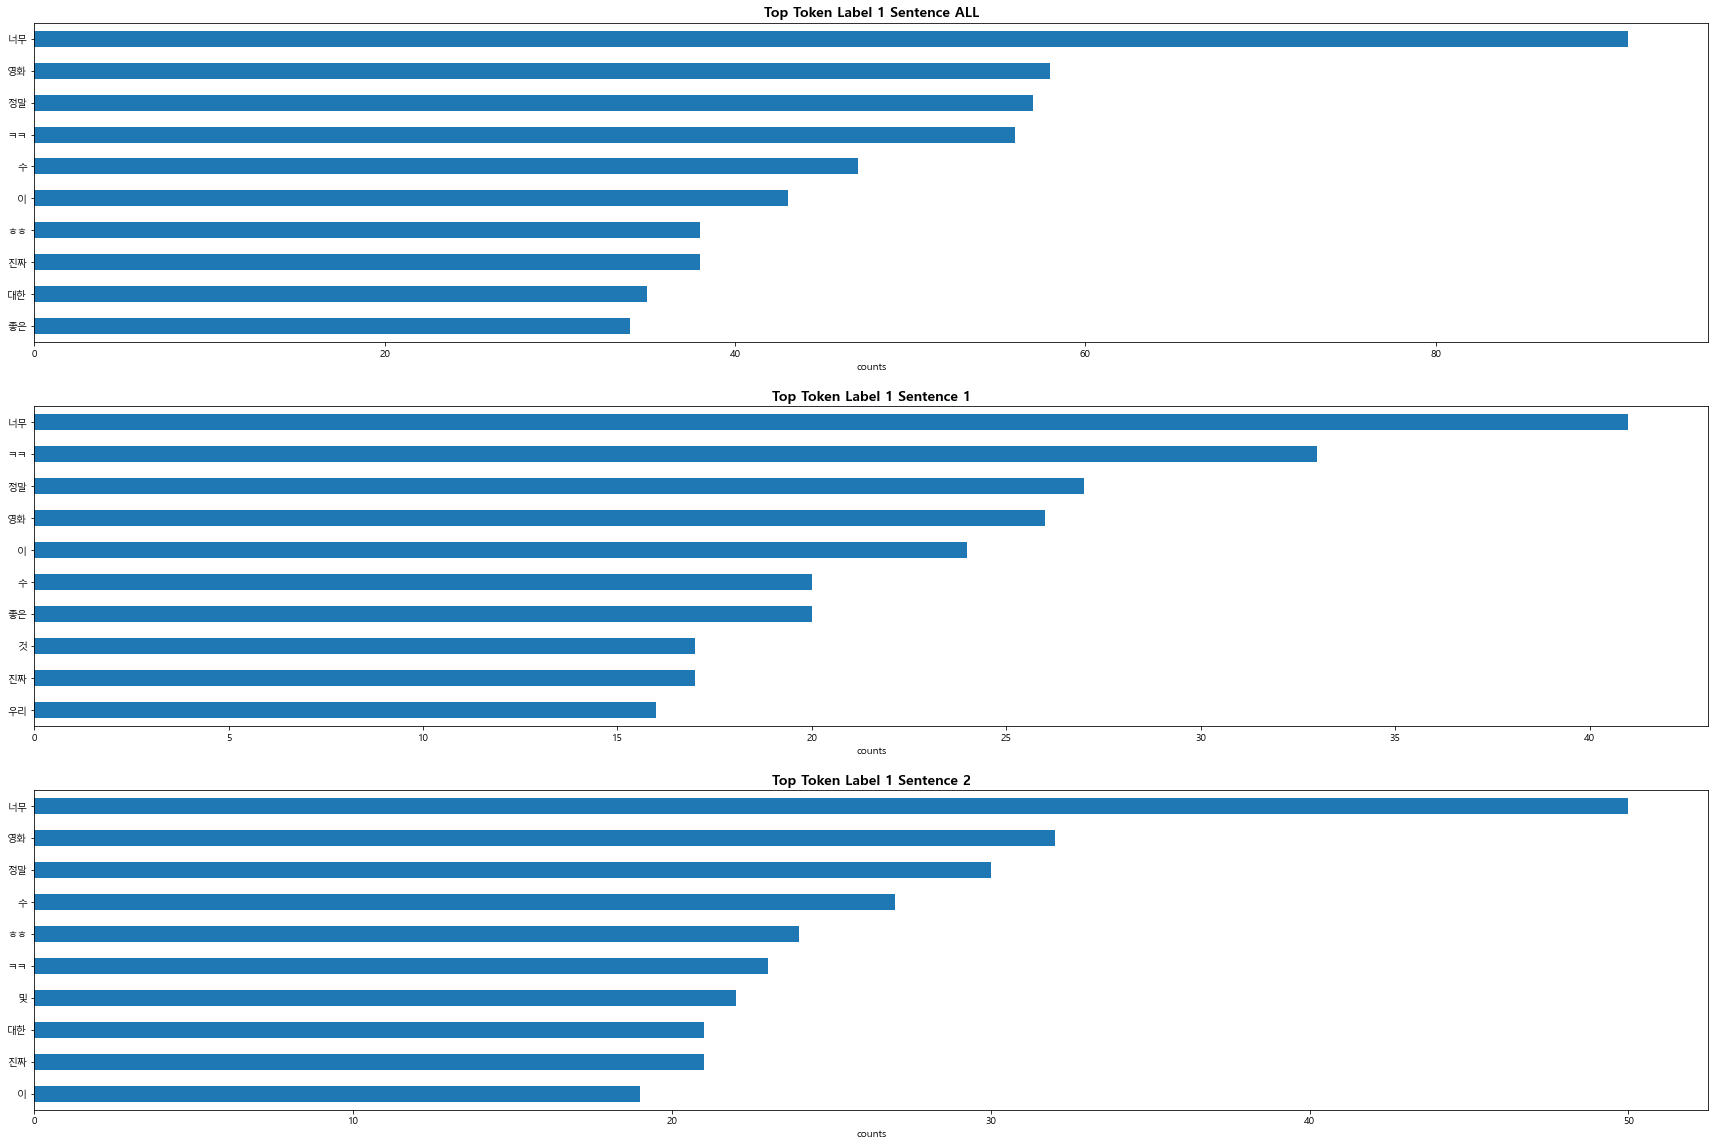

In [51]:
fig = plt.figure(figsize = (30,20))
ax1 = fig.add_subplot(311)
ax1= pd.Series(Counter(train_pd[train_pd['simple_label']==1]['tokens_a'].agg('sum'))).sort_values(ascending=False).head(10).plot(kind='barh')
ax1.set_title("Top Token Label 1 Sentence ALL", fontsize=14, fontweight='bold')
ax1.set_xlabel("counts", fontsize = 10)
ax1.set_ylabel("")
ax1.invert_yaxis()

ax2 = fig.add_subplot(312)
ax2= pd.Series(Counter(train_pd[train_pd['simple_label']==1]['tokens_1'].agg('sum'))).sort_values(ascending=False).head(10).plot(kind='barh')
ax2.set_title("Top Token Label 1 Sentence 1", fontsize=14, fontweight='bold')
ax2.set_xlabel("counts", fontsize = 10)
ax2.set_ylabel("")
ax2.invert_yaxis()

ax3 = fig.add_subplot(313)
ax3 = pd.Series(Counter(train_pd[train_pd['simple_label']==1]['tokens_2'].agg('sum'))).sort_values(ascending=False).head(10).plot(kind='barh')
ax3.set_title("Top Token Label 1 Sentence 2", fontsize=14, fontweight='bold')
ax3.set_xlabel("counts", fontsize = 10)
ax3.set_ylabel("")
ax3.invert_yaxis()

plt.show()

#### Label 2

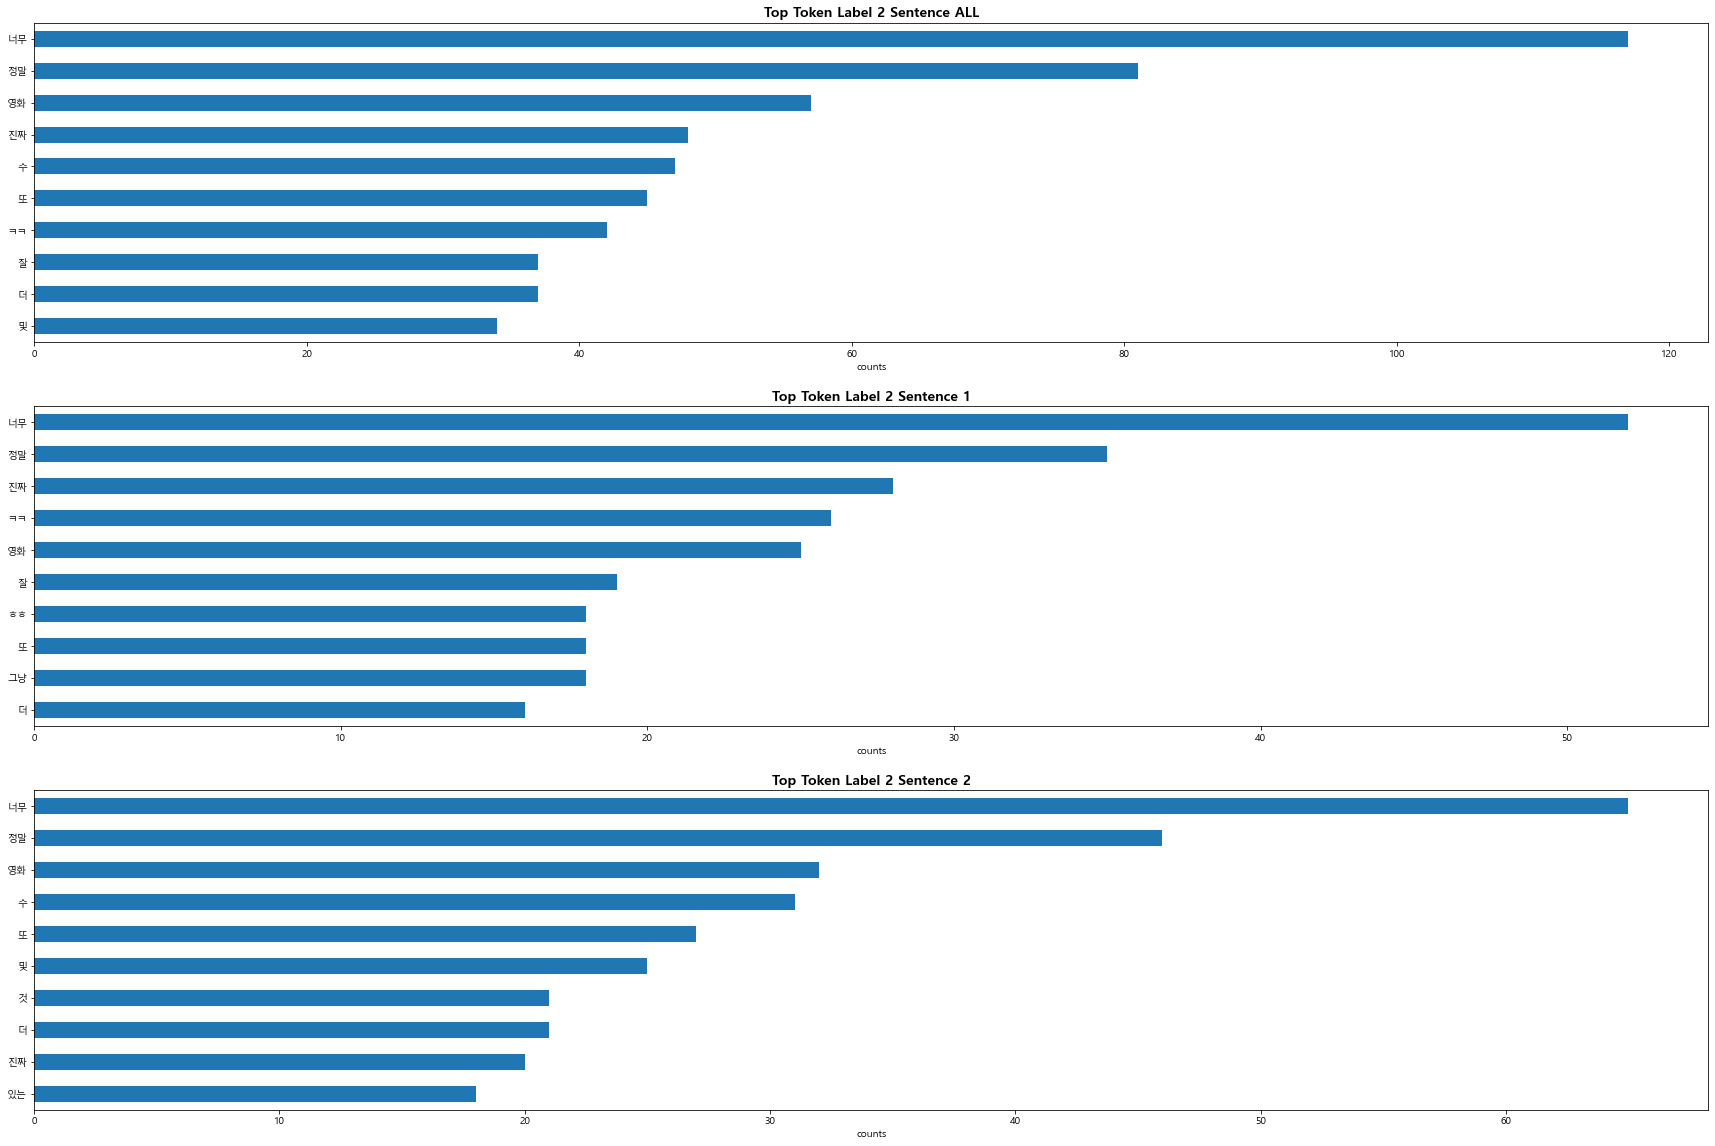

In [52]:
fig = plt.figure(figsize = (30,20))
ax1 = fig.add_subplot(311)
ax1= pd.Series(Counter(train_pd[train_pd['simple_label']==2]['tokens_a'].agg('sum'))).sort_values(ascending=False).head(10).plot(kind='barh')
ax1.set_title("Top Token Label 2 Sentence ALL", fontsize=14, fontweight='bold')
ax1.set_xlabel("counts", fontsize = 10)
ax1.set_ylabel("")
ax1.invert_yaxis()

ax2 = fig.add_subplot(312)
ax2= pd.Series(Counter(train_pd[train_pd['simple_label']==2]['tokens_1'].agg('sum'))).sort_values(ascending=False).head(10).plot(kind='barh')
ax2.set_title("Top Token Label 2 Sentence 1", fontsize=14, fontweight='bold')
ax2.set_xlabel("counts", fontsize = 10)
ax2.set_ylabel("")
ax2.invert_yaxis()

ax3 = fig.add_subplot(313)
ax3 = pd.Series(Counter(train_pd[train_pd['simple_label']==2]['tokens_2'].agg('sum'))).sort_values(ascending=False).head(10).plot(kind='barh')
ax3.set_title("Top Token Label 2 Sentence 2", fontsize=14, fontweight='bold')
ax3.set_xlabel("counts", fontsize = 10)
ax3.set_ylabel("")
ax3.invert_yaxis()

plt.show()

#### Label 3

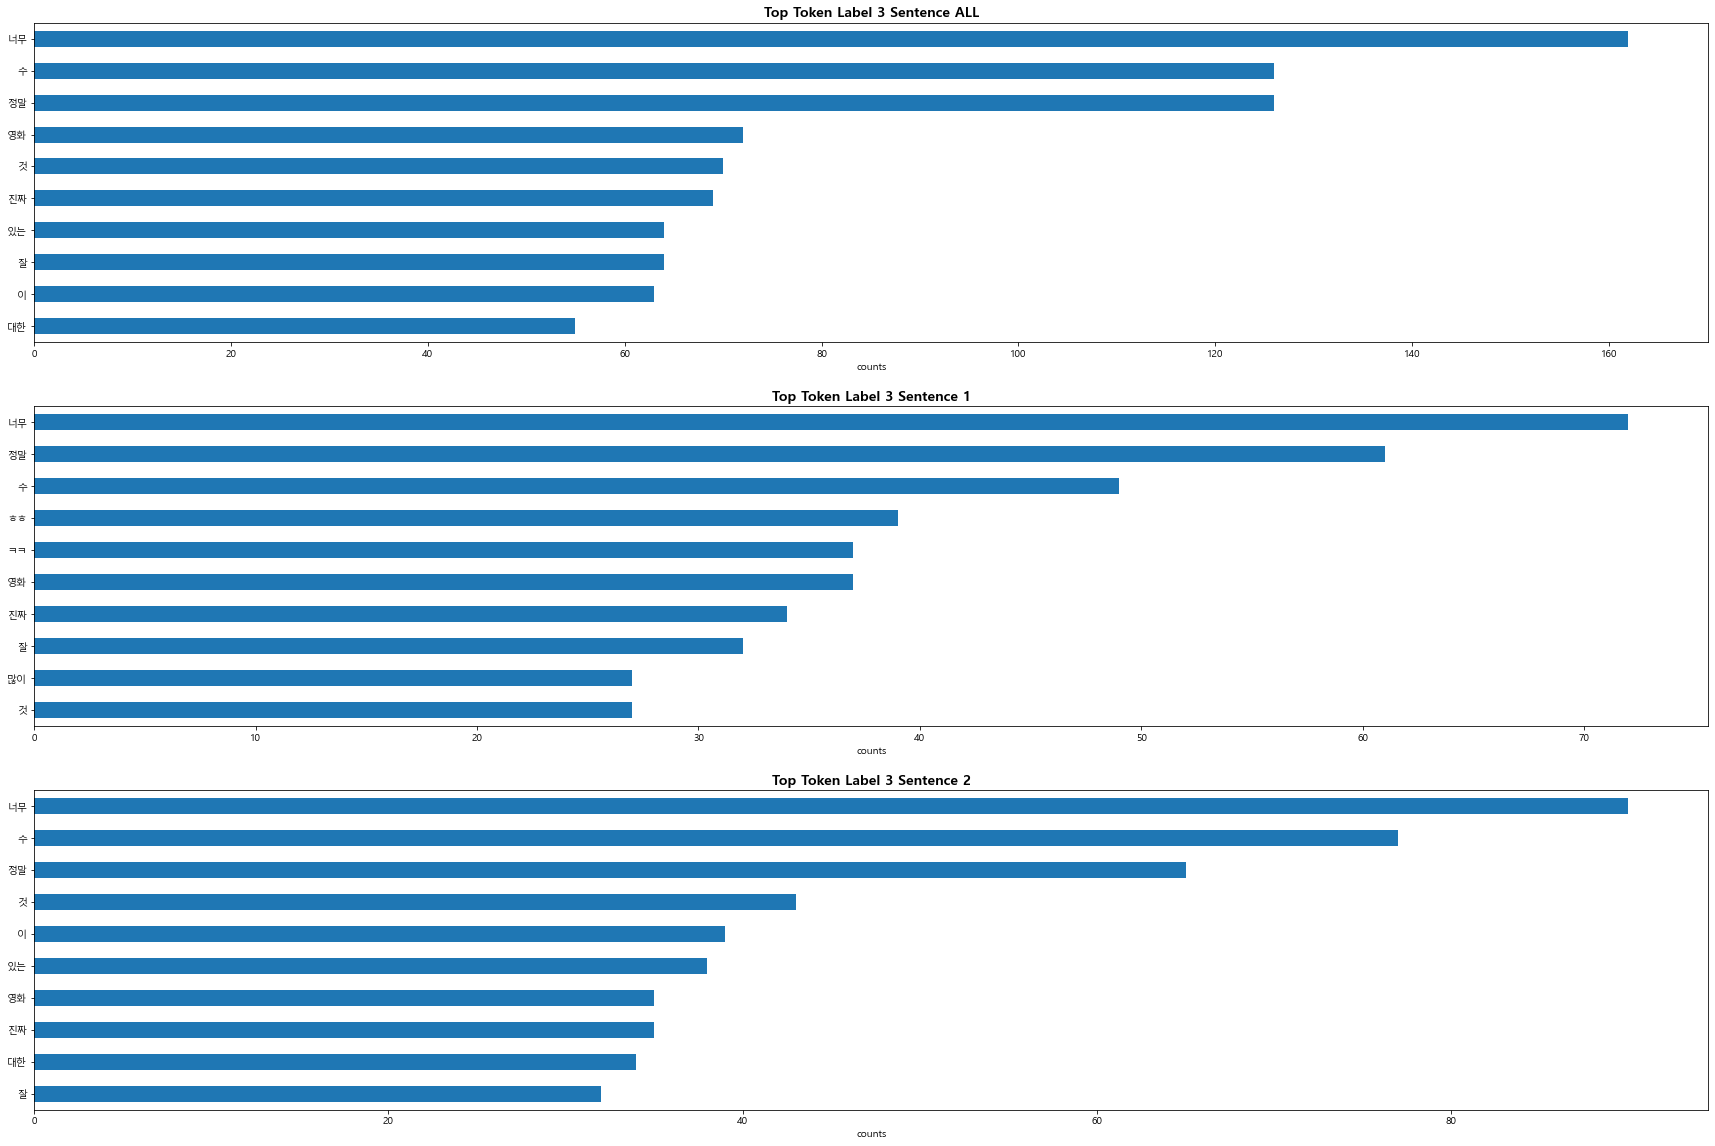

In [53]:
fig = plt.figure(figsize = (30,20))
ax1 = fig.add_subplot(311)
ax1= pd.Series(Counter(train_pd[train_pd['simple_label']==3]['tokens_a'].agg('sum'))).sort_values(ascending=False).head(10).plot(kind='barh')
ax1.set_title("Top Token Label 3 Sentence ALL", fontsize=14, fontweight='bold')
ax1.set_xlabel("counts", fontsize = 10)
ax1.set_ylabel("")
ax1.invert_yaxis()

ax2 = fig.add_subplot(312)
ax2= pd.Series(Counter(train_pd[train_pd['simple_label']==3]['tokens_1'].agg('sum'))).sort_values(ascending=False).head(10).plot(kind='barh')
ax2.set_title("Top Token Label 3 Sentence 1", fontsize=14, fontweight='bold')
ax2.set_xlabel("counts", fontsize = 10)
ax2.set_ylabel("")
ax2.invert_yaxis()

ax3 = fig.add_subplot(313)
ax3 = pd.Series(Counter(train_pd[train_pd['simple_label']==3]['tokens_2'].agg('sum'))).sort_values(ascending=False).head(10).plot(kind='barh')
ax3.set_title("Top Token Label 3 Sentence 2", fontsize=14, fontweight='bold')
ax3.set_xlabel("counts", fontsize = 10)
ax3.set_ylabel("")
ax3.invert_yaxis()

plt.show()

#### Label 4

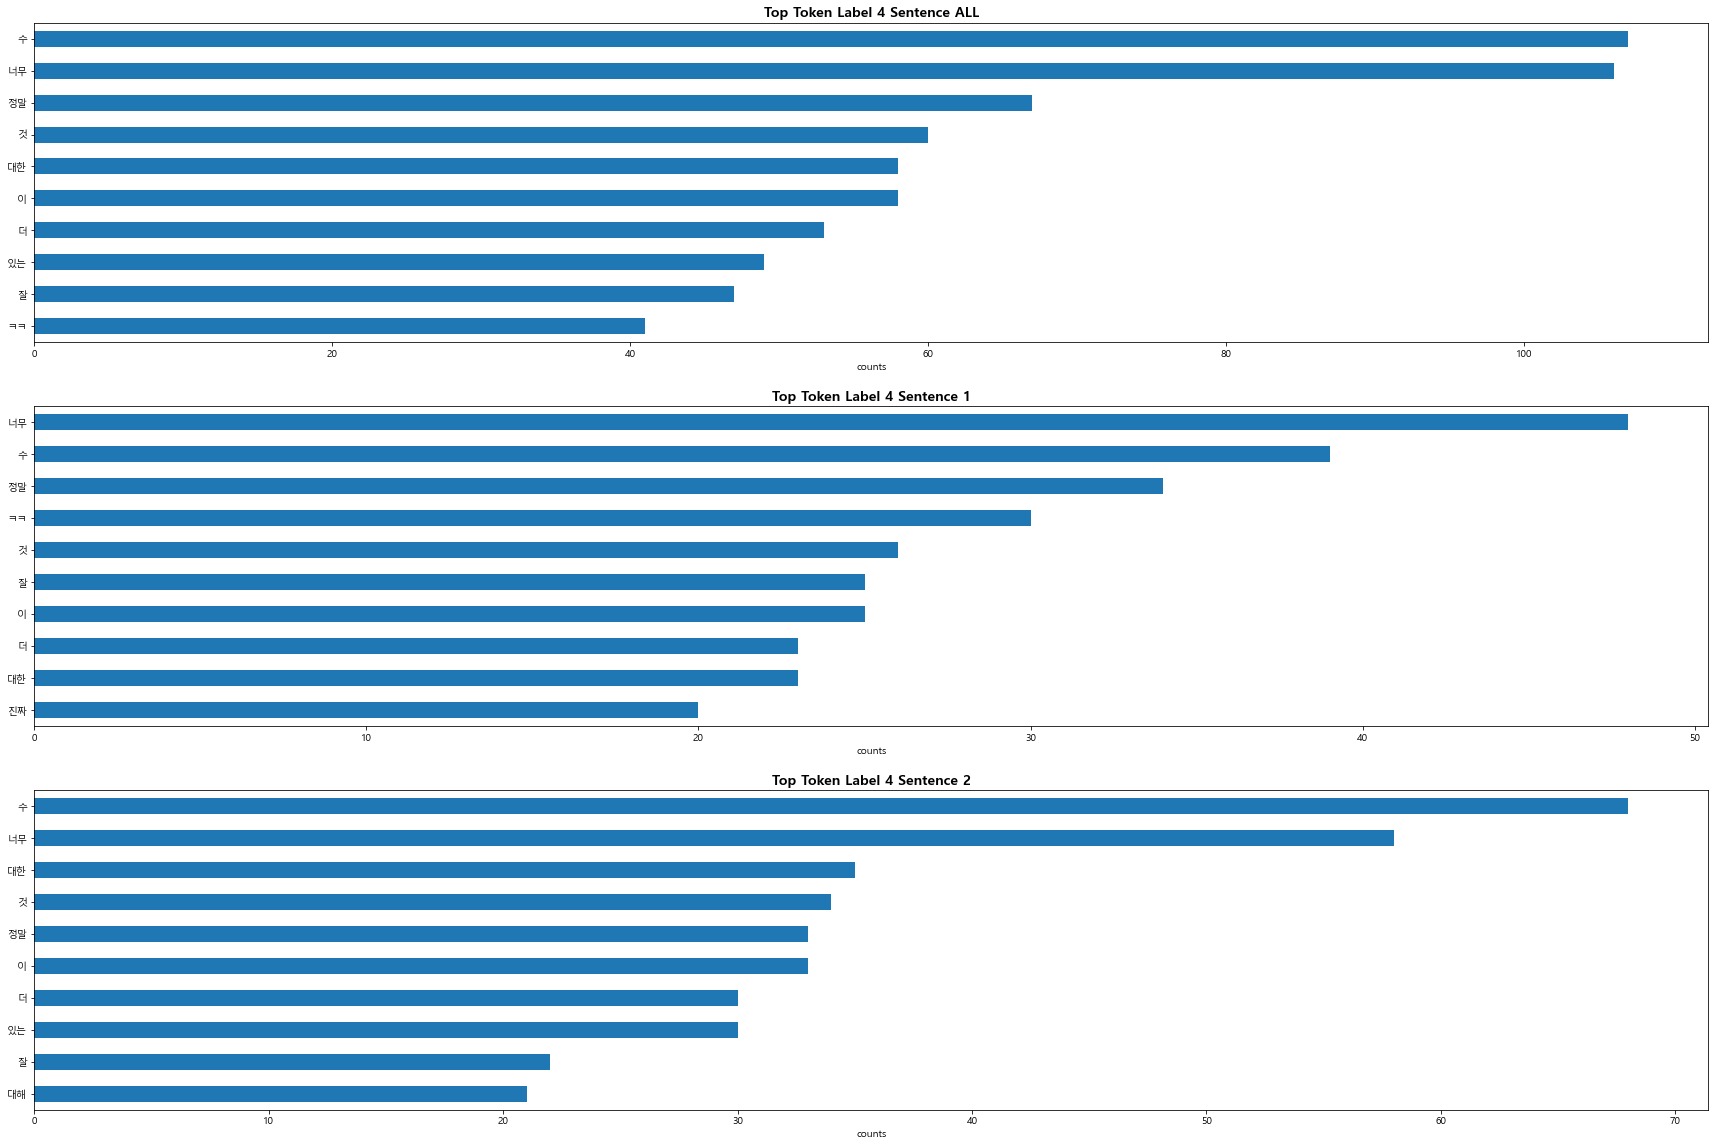

In [54]:
fig = plt.figure(figsize = (30,20))
ax1 = fig.add_subplot(311)
ax1= pd.Series(Counter(train_pd[train_pd['simple_label']==4]['tokens_a'].agg('sum'))).sort_values(ascending=False).head(10).plot(kind='barh')
ax1.set_title("Top Token Label 4 Sentence ALL", fontsize=14, fontweight='bold')
ax1.set_xlabel("counts", fontsize = 10)
ax1.set_ylabel("")
ax1.invert_yaxis()

ax2 = fig.add_subplot(312)
ax2= pd.Series(Counter(train_pd[train_pd['simple_label']==4]['tokens_1'].agg('sum'))).sort_values(ascending=False).head(10).plot(kind='barh')
ax2.set_title("Top Token Label 4 Sentence 1", fontsize=14, fontweight='bold')
ax2.set_xlabel("counts", fontsize = 10)
ax2.set_ylabel("")
ax2.invert_yaxis()

ax3 = fig.add_subplot(313)
ax3 = pd.Series(Counter(train_pd[train_pd['simple_label']==4]['tokens_2'].agg('sum'))).sort_values(ascending=False).head(10).plot(kind='barh')
ax3.set_title("Top Token Label 4 Sentence 2", fontsize=14, fontweight='bold')
ax3.set_xlabel("counts", fontsize = 10)
ax3.set_ylabel("")
ax3.invert_yaxis()

plt.show()

#### Label 5

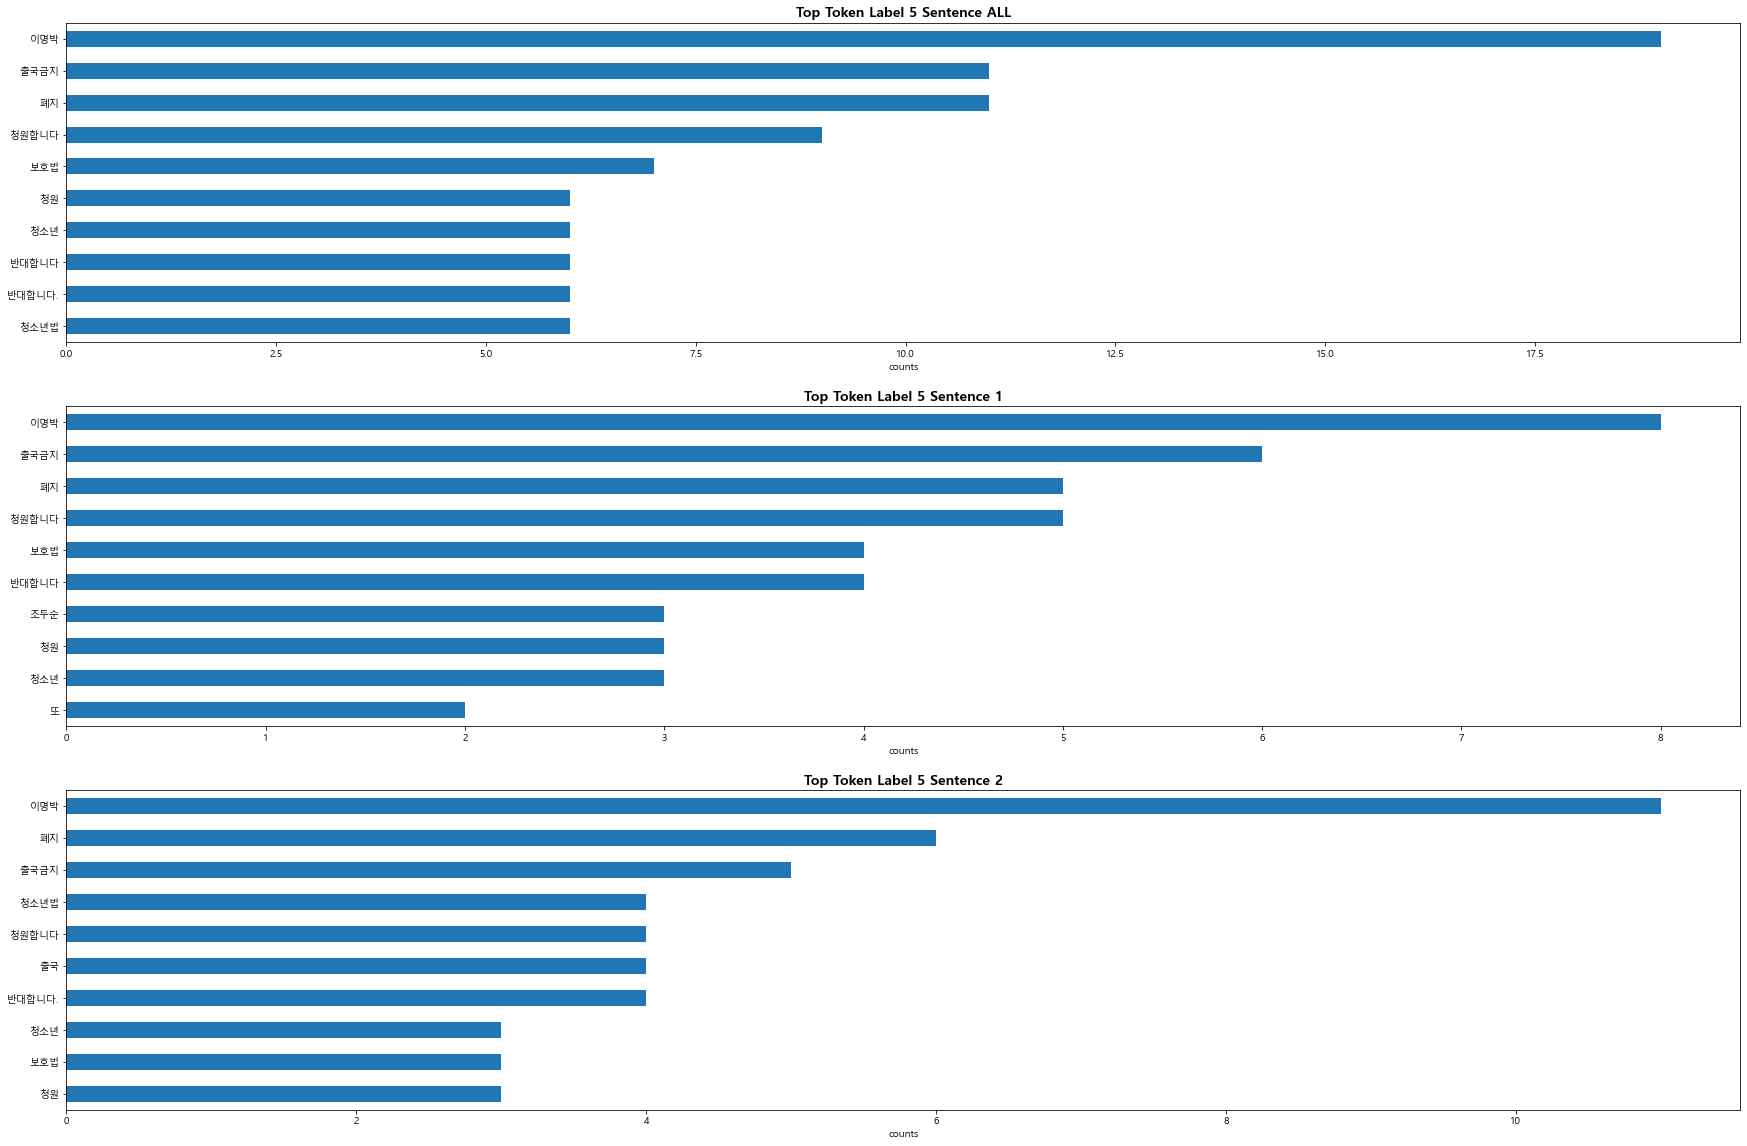

In [55]:
fig = plt.figure(figsize = (30,20))
ax1 = fig.add_subplot(311)
ax1= pd.Series(Counter(train_pd[train_pd['simple_label']==5]['tokens_a'].agg('sum'))).sort_values(ascending=False).head(10).plot(kind='barh')
ax1.set_title("Top Token Label 5 Sentence ALL", fontsize=14, fontweight='bold')
ax1.set_xlabel("counts", fontsize = 10)
ax1.set_ylabel("")
ax1.invert_yaxis()

ax2 = fig.add_subplot(312)
ax2= pd.Series(Counter(train_pd[train_pd['simple_label']==5]['tokens_1'].agg('sum'))).sort_values(ascending=False).head(10).plot(kind='barh')
ax2.set_title("Top Token Label 5 Sentence 1", fontsize=14, fontweight='bold')
ax2.set_xlabel("counts", fontsize = 10)
ax2.set_ylabel("")
ax2.invert_yaxis()

ax3 = fig.add_subplot(313)
ax3 = pd.Series(Counter(train_pd[train_pd['simple_label']==5]['tokens_2'].agg('sum'))).sort_values(ascending=False).head(10).plot(kind='barh')
ax3.set_title("Top Token Label 5 Sentence 2", fontsize=14, fontweight='bold')
ax3.set_xlabel("counts", fontsize = 10)
ax3.set_ylabel("")
ax3.invert_yaxis()

plt.show()

불용어 처리나 태깅 등의 방법으로 토큰을 필터링하지 않아 몇몇 단어가 라벨 상관 없이 많이 관측되는 것을 볼 수 있었다.     
영화 감성 분석 데이터가 다른 2 데이터셋에 비해 유별히 많은 것이 아닌데도 '영화'라는 단어가 많이 나타났다.     
불용어 처리를 한 후, 품사나 NER 태깅을 붙인 다음에 유효한 token을 찾아 위의 방법론을 다시 적용한다면 좀 더 의미있는 분석이 될 것 같다.     

#### 단어에 대한 짧은 첨언

In [56]:
pd.Series(Counter(train_pd['tokens_1'].agg('sum'))).sort_values(ascending=True).head(15)

스릴도있고      1
의견들        1
모듈화        1
법제화        1
직접고용       1
사내하청을      1
중이예용ㅋㅋ     1
똑같아지는      1
동여매서       1
헤헷         1
봐야죠        1
(두분        1
실패작?       1
랜덤일까요~?    1
진입문제       1
dtype: int64

In [57]:
pd.Series(Counter(train_pd['tokens_2'].agg('sum'))).sort_values(ascending=True).head(15)

막아야       1
않았나       1
였어야       1
혓소리       1
꼬부라진      1
단지,       1
다;;       1
평들이       1
재밌음;;     1
영화보다도     1
요즘나오는     1
클릭!       1
이모티콘을     1
컸다...ㅋ    1
취업의       1
dtype: int64

비문법적인 표현이나 인터넷 용어 표현이 꽤 많이 보이고 띄어쓰기가 잘 되지 않은 단어 흔적들 또한 많이 보인다.    
해당 표현들을 찾아서 올바른 표현으로 치환해주는 것이 필요해 보인다.     

## EDA by source

### source 별 데이터 수 및 비율 시각화

In [58]:
train_pd['source'].value_counts().sort_index()

nsmc-rtt             788
nsmc-sampled        2296
petition-rtt         817
petition-sampled    2352
slack-rtt           1047
slack-sampled       2024
Name: source, dtype: int64

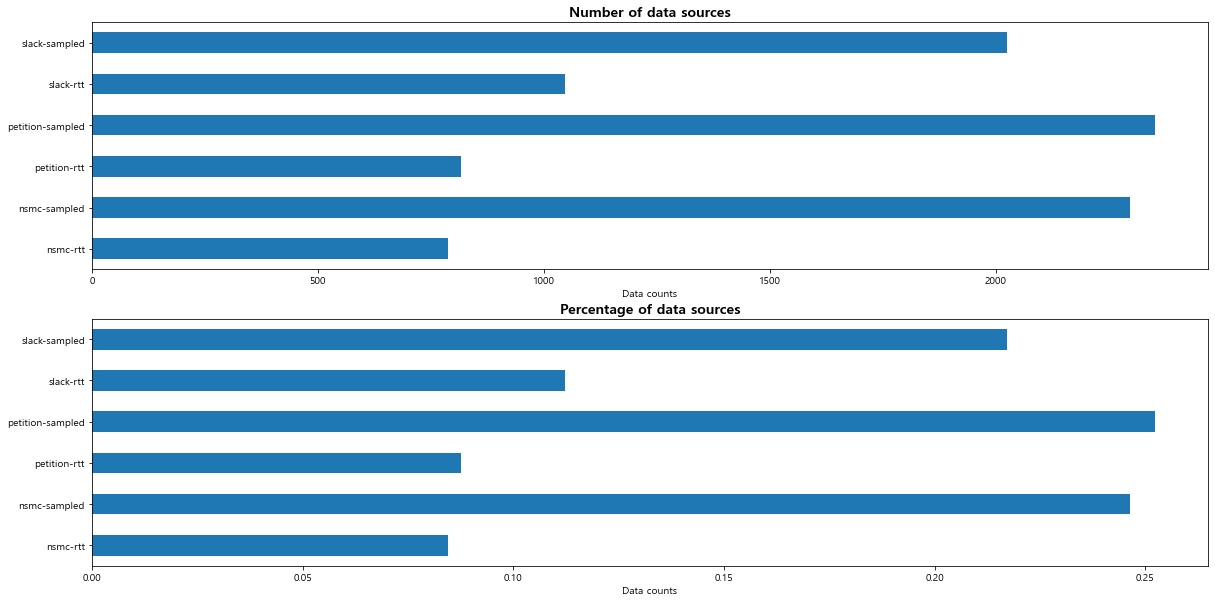

In [59]:
fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(211)
ax1 = train_pd['source'].value_counts().sort_index().plot(kind='barh')
ax1.set_title("Number of data sources", fontsize=14, fontweight='bold')
ax1.set_xlabel("Data counts", fontsize = 10)
ax1.set_ylabel("")


ax2 = fig.add_subplot(212)
ax2 = train_pd['source'].value_counts(normalize=True).sort_index().plot(kind='barh')
ax2.set_title("Percentage of data sources", fontsize=14, fontweight='bold')
ax2.set_xlabel("Data counts", fontsize = 10)
ax2.set_ylabel("")

plt.show()

### source 및 label 별 데이터 비율 확인

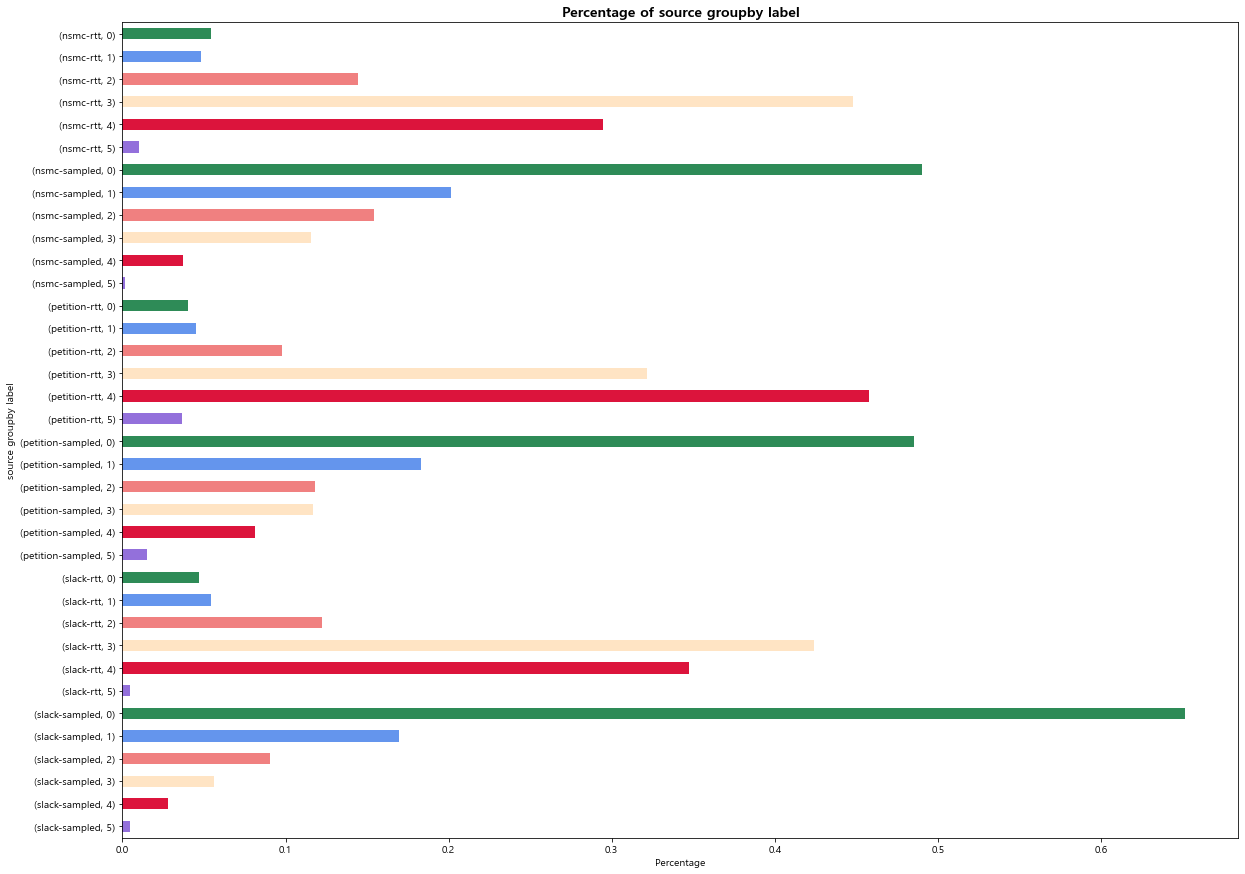

In [60]:
fig = plt.figure(figsize = (20,15))

ax1 = train_pd.groupby('source')['simple_label'].value_counts(normalize=True).sort_index()\
    .plot(kind='barh',color=['seagreen','cornflowerblue','lightcoral','bisque','crimson','mediumpurple'])
ax1.set_title("Percentage of source groupby label", fontsize=14, fontweight='bold')
ax1.set_xlabel("Percentage", fontsize = 10)
ax1.set_ylabel("source groupby label")
ax1.invert_yaxis()

plt.show()

label 별, source 별 데이터의 숫자나 비율이 상이해서 이것을 맞춰서 학습하는 것도 의미를 가지지 않을까 생각이 든다.

#### sampled 와 rtt 에 대한 고찰

In [61]:
train_pd[train_pd['source']=='nsmc-sampled'][['source','sentence_1','sentence_2']].head()

,source,sentence_1,sentence_2
0,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요."
7,nsmc-sampled,이렇게 귀여운 쥐들은 처음이네요.ㅎㅎㅎ,이렇게 지겨운 공포영화는 처음..
11,nsmc-sampled,극의전개가너무느릿하여답답합니다,전개가 너무 느려서 속터진다
13,nsmc-sampled,글쎄.. 특색도 없고 별로였던 걸로 기억하는데..,큰 반전 없던걸로 기억하는데...
23,nsmc-sampled,노래와 잘 어우러지는 영상 덕분인지 짧지만 강한 인상이 남네요..,조금유치하지만 가볍게 볼수는 있는영화네요!


In [62]:
train_pd[train_pd['source']=='nsmc-rtt'][['source','sentence_1','sentence_2']].head()

,source,sentence_1,sentence_2
5,nsmc-rtt,오마이가뜨지져스크롸이스트휏,오 마이 갓 지저스 스크론 이스트 팬
12,nsmc-rtt,오랫만에 존쿠삭의 연기보니 좋네요 Good~~!!,오랜만에 존 쿠삭의 연기를 보니 반갑다. 좋아요~~!!
24,nsmc-rtt,군대가기전에 봤었는데 진짜 윈터스같은 사람이 상관이면 목숨걸고 싸워도 후회는 없지 ...,입대하기 전에 봤는데 윈터스 같은 사람이 진심으로 아껴준다면 목숨을 걸고 싸워도 후...
29,nsmc-rtt,한사람의 파멸을 적나라하게 드러내 준 영화,한 사람의 파멸을 드러내는 영화
34,nsmc-rtt,전설따라 삼천리(삼만리인가?)에 의하면 이 영화가 꽤 괜찮다고 할뿐 아니라 내가 좋...,전설에 따르면 삼천리(삼천리?)에 따르면 이 영화는 꽤 괜찮을 뿐만 아니라 내가 제...


sampled 와 rtt가 무엇을 의미하는지 모르겠다. 질문해봐야 할듯

## n_gram 접근법

### sentence1

In [63]:
def get_n_grams(n_grams, sen, top_n = 10):
    df_words = pd.DataFrame()
    for dt in tqdm(sorted(list(train_pd['simple_label'].unique()))):
        df = train_pd.query('simple_label == @dt')
        texts = df['sentence_'+str(sen)].tolist()
        vec = CountVectorizer(ngram_range=(n_grams, n_grams)).fit(texts)
        bag_of_words = vec.transform(texts)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        cvec_df = pd.DataFrame.from_records(words_freq,\
                                            columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
        cvec_df.insert(0, "Label", dt)
        cvec_df = cvec_df.iloc[:top_n,:]
        df_words = df_words.append(cvec_df)
    return df_words

In [64]:
bigrams = get_n_grams(n_grams = 2, sen=1, top_n=10)
bigrams.head()

  0%|          | 0/6 [00:00<?, ?it/s]

,Label,words,counts
78,0,person 님과,15
1345,0,우리 회사,7
2607,0,만들어 주세요,7
68,0,person 님이,6
694,0,이야기를 나눴습니다,5


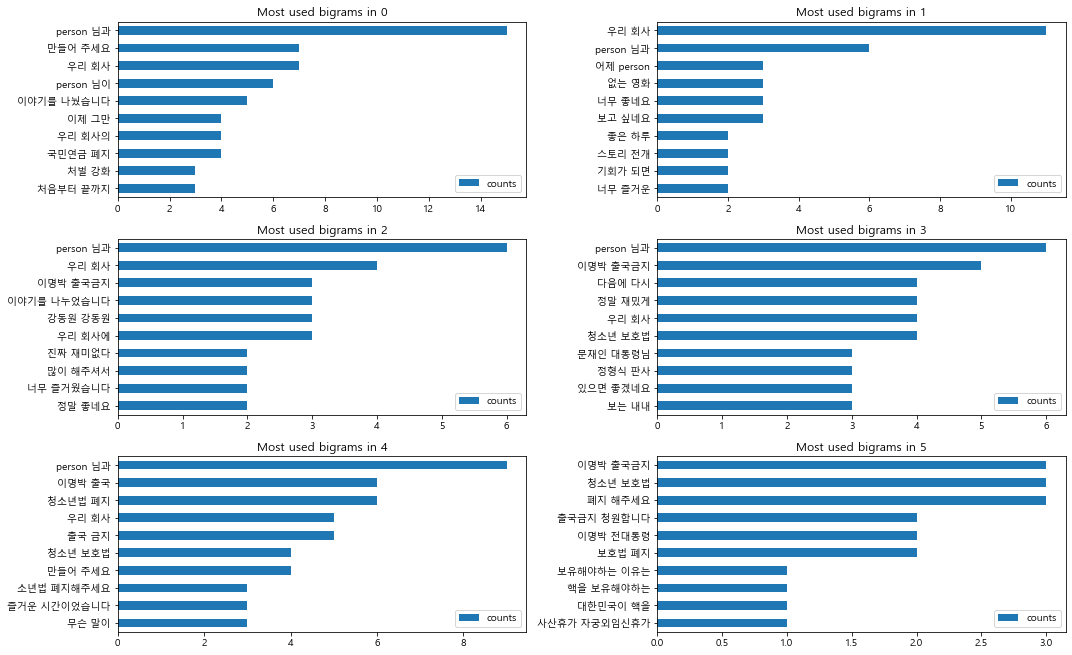

In [65]:
def plot_ngram(df, type = "bigrams"):
    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)

    for n, dt in enumerate(df.Label.unique()):
        ax = plt.subplot(4, 2, n + 1)
        ax.set_title(f"Most used {type} in {dt}")
        data = df.query('Label == @dt')[['words', 'counts']].set_index("words").sort_values(by = "counts", ascending = True)
        data.plot(ax=ax, kind = 'barh')
        plt.ylabel("")
    plt.tight_layout()
    plt.show()
    
plot_ngram(bigrams)

  0%|          | 0/6 [00:00<?, ?it/s]

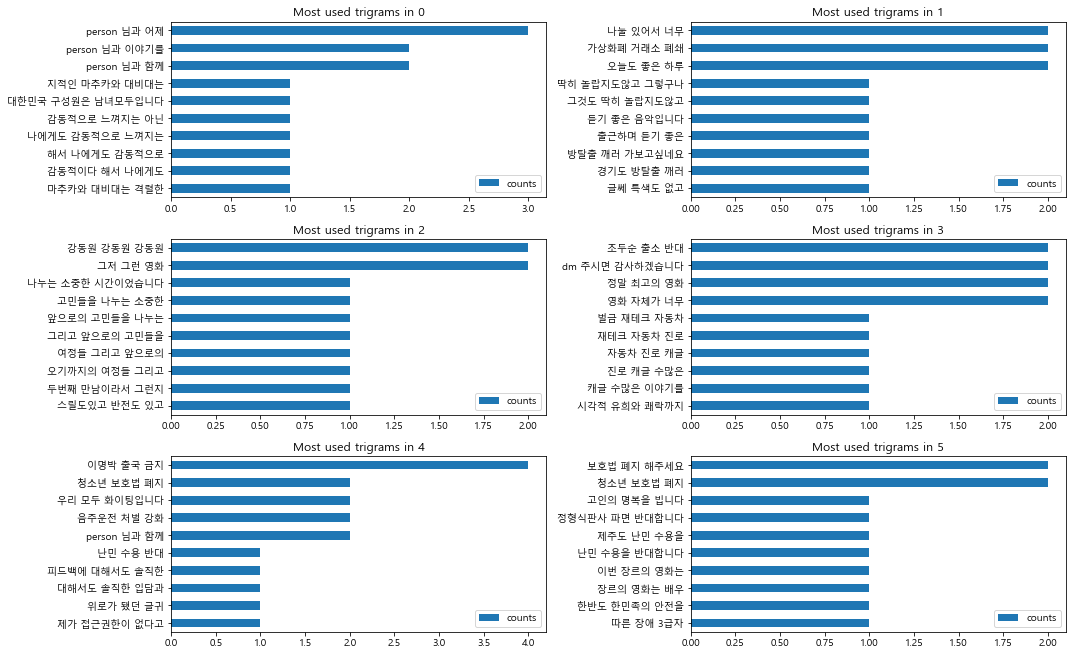

In [66]:
trigrams = get_n_grams(n_grams = 3, sen=1, top_n=10)
plot_ngram(trigrams, type = "trigrams")

### sentence2

  0%|          | 0/6 [00:00<?, ?it/s]

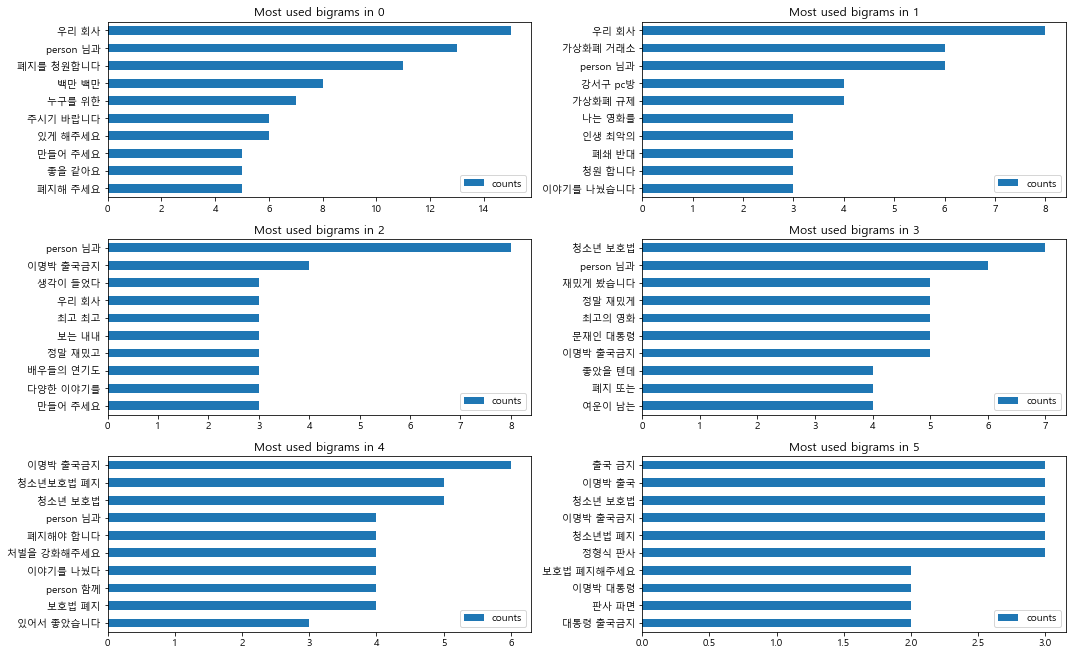

In [67]:
bigrams = get_n_grams(n_grams = 2, sen=2, top_n=10)
plot_ngram(bigrams)

  0%|          | 0/6 [00:00<?, ?it/s]

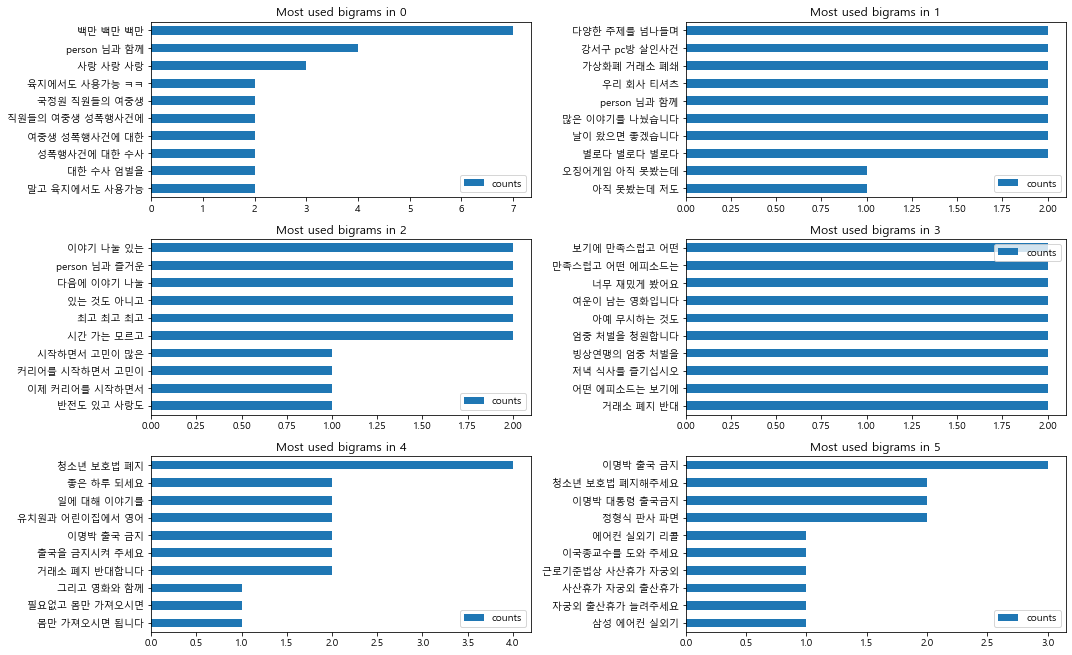

In [68]:
trigrams = get_n_grams(n_grams = 3, sen=2, top_n=10)
plot_ngram(trigrams)

### all sentence

  0%|          | 0/6 [00:00<?, ?it/s]

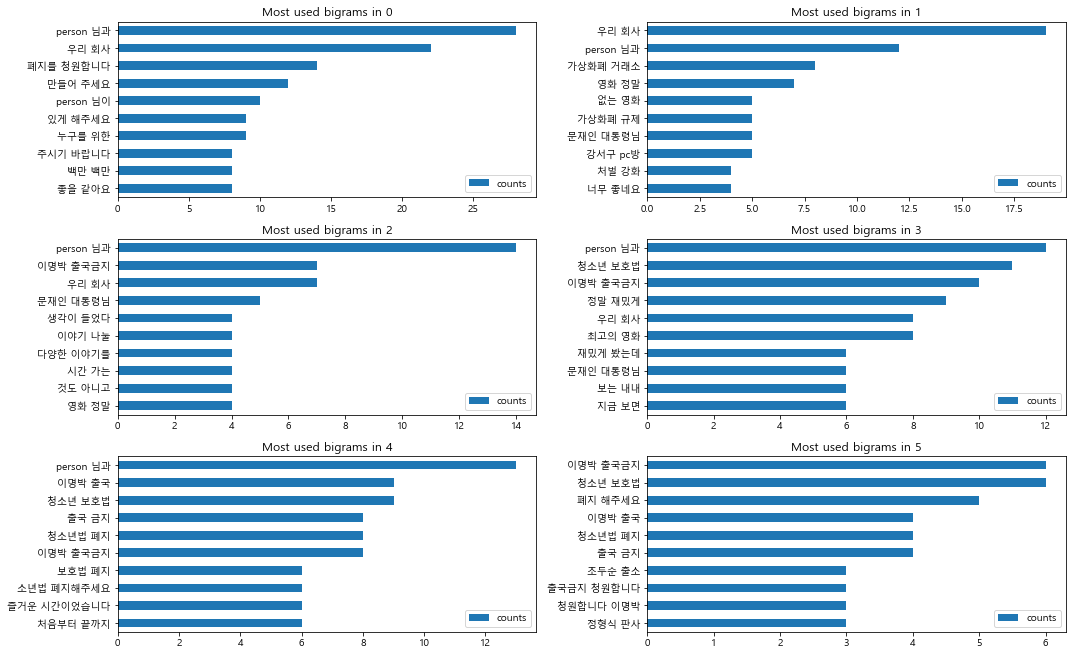

In [69]:
bigrams = get_n_grams(n_grams = 2, sen='a', top_n=10)
plot_ngram(bigrams)

  0%|          | 0/6 [00:00<?, ?it/s]

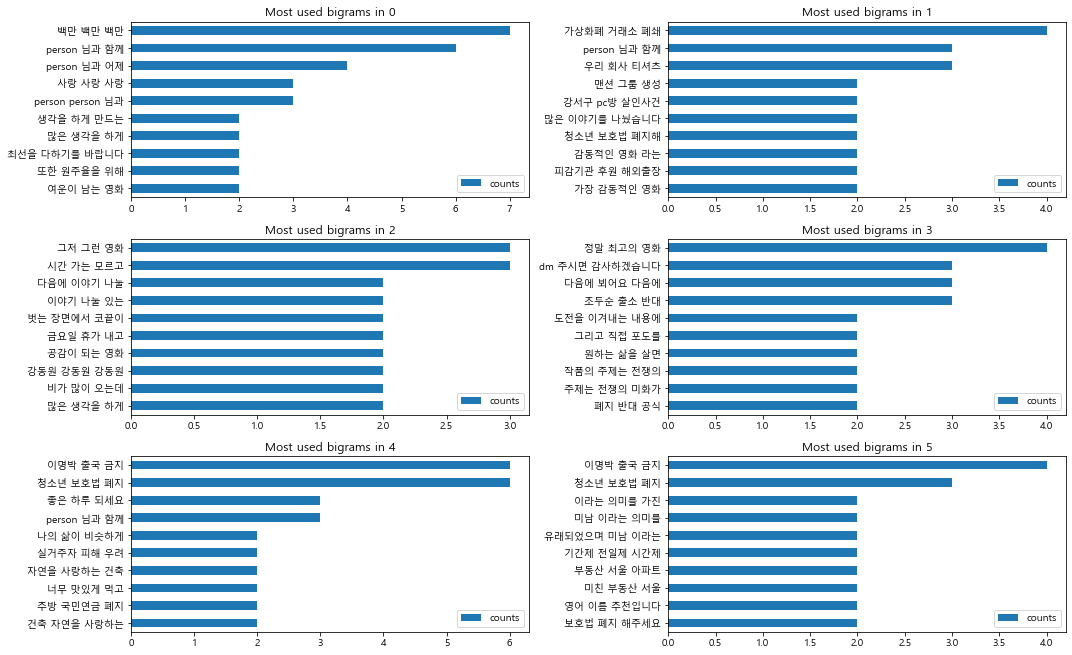

In [70]:
trigrams = get_n_grams(n_grams = 3, sen='a', top_n=10)
plot_ngram(trigrams)

문장 1과 문장 2, 그리고 양 문장의 빈출 n-gram을 뽑아보았다.   
여기서 어떠한 인사이트를 찾을 수 있다면 좋겠다.   
사실 문장 1과 문장 2의 유사도를 측정하는 거니까 1,2 순서를 바꿔 학습 데이터를 늘리는 것도 방법이 되지 않을까 싶다.   

이 자체에서 아이디어나 인사이트를 주었으면 좋겠지만 그게 아니더라도    
데이터 프레임 변형에 대한 아이디어를 얻어간다면 그것만으로도 만족스럽다.   
단순한 걸 못해서 몇십 분씩 막히고 했던 기억이 뼈아프다.   
누군가는 그러지 않았음 한다.

일전에 참여한 캐글 대회의 EDA 코드를 일부 참고하였으며    
그외의 부분은 본인이 궁금한 부분에 대해 직접 작성하였다.   
그럼 이만 마무리하겠다. 감사하다:)   

## reference

[Check for NaN](https://datatofish.com/check-nan-pandas-dataframe/ "check nan")

[Kaggle NLP EDA](https://www.kaggle.com/code/erikbruin/nlp-on-student-writing-eda "nlp kaggle")